In [14]:
import pandas as pd

student_housing = pd.read_csv('student_housing.csv')  

student_housing['StreetNumber'] = student_housing['6a. street #'].astype(str).str.strip()
student_housing['StreetNameOnly'] = student_housing['6b. street name'].astype(str).str.strip()
student_housing['Zip'] = student_housing['6e. zip'].astype(str).str.zfill(5)


/var/folders/h7/4njx58kj1q3fjd0lhgg72pq80000gn/T/ipykernel_98703/3817422691.py:3: DtypeWarning: Columns (4,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  student_housing = pd.read_csv('student_housing.csv')


In [15]:
property_2024 = pd.read_csv('property_assessment_2024.csv')  # Replace with your actual path

property_2024['ST_NUM'] = property_2024['ST_NUM'].fillna('0').astype(str).str.strip()
property_2024['ST_NUM'] = property_2024['ST_NUM'].str.split().str[0]
property_2024['ST_NUM'] = property_2024['ST_NUM'].str.split('-').str[0]
property_2024['ST_NUM'] = property_2024['ST_NUM'].str.extract(r'(\d+)')[0].fillna('0')
property_2024['StreetNumber'] = property_2024['ST_NUM'].astype(int).astype(str).str.strip()

property_2024['StreetName'] = property_2024['ST_NAME'].astype(str).str.strip().str.upper()
property_2024['StreetName'] = property_2024['StreetName'].str.split().str[0]

property_2024['ZIP_CODE'] = property_2024['ZIP_CODE'].astype(str).str.extract(r'(\d+)')[0].fillna('00000')
property_2024['Zip'] = property_2024['ZIP_CODE'].str.zfill(5)


/var/folders/h7/4njx58kj1q3fjd0lhgg72pq80000gn/T/ipykernel_98703/3386728893.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  property_2024 = pd.read_csv('property_assessment_2024.csv')  # Replace with your actual path


In [16]:
merged_2024 = pd.merge(student_housing, property_2024,
                       left_on=['StreetNumber', 'StreetNameOnly', 'Zip'],
                       right_on=['StreetNumber', 'StreetName', 'Zip'],
                       how='inner')

print(f"✅ Matched {len(merged_2024)} student housing units in 2024.")


✅ Matched 112538 student housing units in 2024.


In [17]:
merged_2024['TOTAL_VALUE'] = (
    merged_2024['TOTAL_VALUE']
    .astype(str)
    .str.replace(',', '', regex=False)
    .str.replace('$', '', regex=False)
    .str.strip()
    .astype(float)
)


Accuracy: 0.9477074817842545
Precision: 0.8835192069392813
Recall: 0.3969933184855234


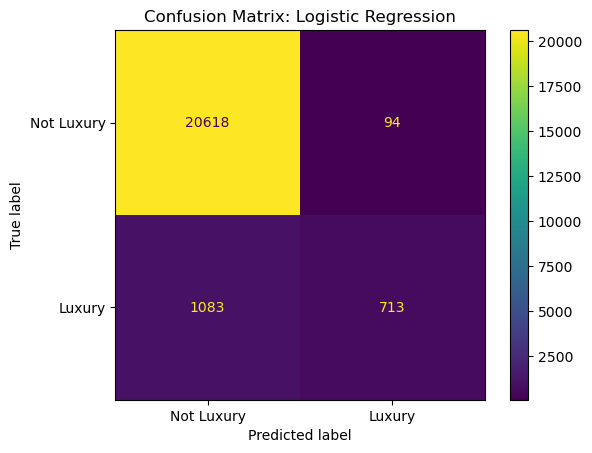


Feature Importances:
       Feature  Coefficient
4  NUM_PARKING     0.852476
1  LIVING_AREA     0.000820
0      LAND_SF     0.000083
2     YR_BUILT    -0.000224
3    RES_UNITS    -3.679255


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

data = merged_2024.copy()

data['is_luxury'] = (data['TOTAL_VALUE'] > 2000000).astype(int)

features = ['LAND_SF', 'LIVING_AREA', 'YR_BUILT', 'RES_UNITS', 'NUM_PARKING']

for col in features:
    data[col] = data[col].astype(str).str.replace(',', '', regex=False).astype(float)

X = data[features].fillna(0)
y = data['is_luxury']

y = data['is_luxury']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000, random_state=42)  # More iterations to ensure convergence
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Luxury', 'Luxury'])
disp.plot()
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': clf.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importances:")
print(coef_df)


/var/folders/h7/4njx58kj1q3fjd0lhgg72pq80000gn/T/ipykernel_98703/459934977.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')


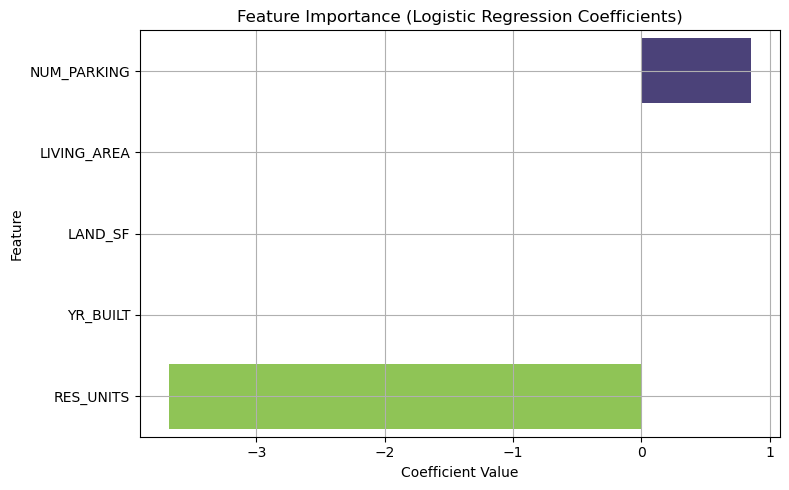

In [19]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')

plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()


is_luxury     0     1  Total   Luxury %
Zip                                    
02119       112   144    256  56.250000
02110      4944  3162   8106  39.008142
02108       385   119    504  23.611111
02116      3802  1094   4896  22.344771
02120       132    37    169  21.893491
02210       282    69    351  19.658120
02215      1320   296   1616  18.316832
02126         5     1      6  16.666667
02115      2143   258   2401  10.745523
02136        10     1     11   9.090909


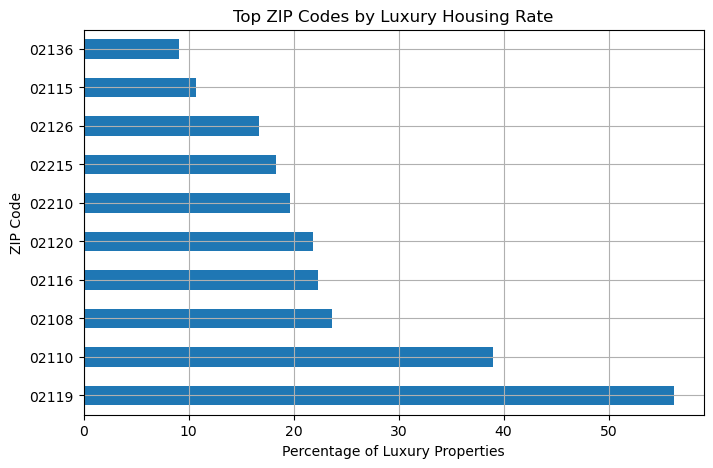

In [20]:
zip_summary = data.groupby(['Zip', 'is_luxury']).size().unstack(fill_value=0)
zip_summary['Total'] = zip_summary.sum(axis=1)
zip_summary['Luxury %'] = (zip_summary[1] / zip_summary['Total']) * 100

top_zipcodes = zip_summary.sort_values('Luxury %', ascending=False).head(10)
print(top_zipcodes)

top_zipcodes['Luxury %'].plot(kind='barh', figsize=(8,5), title='Top ZIP Codes by Luxury Housing Rate')
plt.xlabel('Percentage of Luxury Properties')
plt.ylabel('ZIP Code')
plt.grid(True)
plt.show()

